# Assess Distributions of Computed Properties
Establish what the performance of hMOF MOF looks like given our screens.

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from mofa.utils.conversions import write_to_string
from mofa.scoring.geometry import LatticeParameterChange
from mofa.model import MOFRecord
import pandas as pd
import numpy as np
import gzip
import json

## Load the Data
Get the strains and gas capacities computed using our routines.

In [2]:
strain_data = pd.read_json('mace-strains.jsonl', lines=True)
print(f'Gathered {len(strain_data)} strain calculations')
strain_data.tail()

Gathered 3278 strain calculations


,host,lammps_cmd,timesteps,mof,runtime,strain,structure,steps_ran
3273,aurora-uan-0009,[/lus/flare/projects/MOFA/lward/lammps-kokkos/...,20000,mof-4ff2abfd,5613.509223,1.110463e-16,O Zn O C N C N C N C H O C H O C...,5000.0
3274,aurora-uan-0009,[/lus/flare/projects/MOFA/lward/lammps-kokkos/...,20000,mof-51d9c9a1,5844.535146,1.869479e-18,O Zn O C O N C O C N C O C N C H...,5000.0
3275,aurora-uan-0009,[/lus/flare/projects/MOFA/lward/lammps-kokkos/...,20000,mof-4666c384,5618.761141,2.596884e-18,O Zn O C O N C O C N C O C N C H...,5000.0
3276,aurora-uan-0009,[/lus/flare/projects/MOFA/lward/lammps-kokkos/...,20000,mof-a109f8b5,5899.894337,1.110235e-16,O Zn O C O N C O C N C O C N C H...,5000.0
3277,aurora-uan-0009,[/lus/flare/projects/MOFA/lward/lammps-kokkos/...,20000,mof-10c275ff,7948.442373,1.315028e-18,O Zn O C O N C O C N C O C N C H...,5000.0


Compute the strain with respect to the original structure

In [3]:
strain_data['strain-wrt-0'] = np.nan
names = set(strain_data['mof'])

In [4]:
with gzip.open('data/hmof.json.gz', 'rb') as fp:
    structures = dict(
        (x['name'], MOFRecord(**x))
        for x in map(json.loads, fp) if x['name'] in names
    )

In [5]:
comp = LatticeParameterChange()
def strain_wrt_t0(name: str, strc: str):
    """Compute strain against the first timestep

    Args:
        name: MOF name
        strc: Structure at the current timestsp
    """

    # Add it to a record
    model = structures[name]
    t0 = write_to_string(model.atoms * [2, 2, 2], 'vasp')
    model.md_trajectory['uff'] = [
        (0, t0),
        (1, strc)
    ]

    # Compute strain
    return comp.score_mof(model)

In [6]:
strain_data['strain'] = [strain_wrt_t0(x, y) for x, y in strain_data[['mof', 'structure']].values]

## Plot the Strain Distributions
See what the strain distribution at different run lengths

In [7]:
summaries = strain_data.pivot_table('strain', 'mof', 'timesteps')

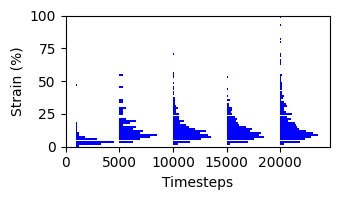

In [8]:
fig, ax = plt.subplots(figsize=(3.5, 2.1))

bins = np.linspace(0, 1., 64)
for i, r in zip(summaries.columns, summaries.values.T):
    hist = np.histogram(r[np.isfinite(r)], bins=bins)[0]
    hist = hist.astype(float) * 3500 / hist.max()
    ax.barh(bins[:-1] * 100, hist, left=i, height=100 / len(bins), align='edge', color='b')

ax.set_xlabel('Timesteps')
ax.set_ylabel('Strain (%)')

ax.set_xlim(0, ax.get_xlim()[1])
ax.set_ylim(0, 100)

fig.tight_layout()